In [1]:
from typing import List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

import utils as u
from models import rotationnality, rotapentzer2014pow
from steps import preprocess
from visualization import papermode

papermode(plt, size=12)


In [2]:
def abbrange(letter:str, a:int, b:int)->Tuple[str]:
    return (f"{letter}{i:02}" for i in range(a,b))

In [3]:
d_abbrs = (*abbrange("D", 1, 7), "D09", "D11", "D12", "D13", "D14", "D16", *abbrange("D", 18, 23))
m_abbrs = abbrange("M", 1, 8)
# p_abbrs = (*abbrange("P", 1, 5), *abbrange("P", 6, 12))
r_abbrs = ("R02", "R03", "R09")
s_abbrs = (*abbrange("S", 1, 11), "S21", "S22", "S23", "S28", "S29", "S30", "S31")
t_abbrs = ("TB",)

abbrs = (
    *d_abbrs,
    *m_abbrs,
    # *p_abbrs,
    *r_abbrs,
    *s_abbrs,
    # *t_abbrs,
)

colors = u.COLORS
cols = {a: colors[u.get_terrain(a)] for a in abbrs}

def add_terrain_legend(mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure]):
    legend_handles = [mpatches.Patch(color=col, label=lab) for lab, col in colors.items()]
    mpl_elem.legend(
        handles=legend_handles, ncol=len(colors), bbox_to_anchor=(0.5, -0.03), loc="upper center", title="Terrain"
    )


In [4]:
terrains = {a: u.get_terrain(a) for a in abbrs}
terrain_abbrs = {}
for abbr, terr in terrains.items():
    terrain_abbrs.setdefault(terr, []).append(abbr)

In [5]:
dfs = {}
pbar = tqdm(abbrs)
for abbr in pbar:
    pbar.set_description(abbr)
    preprocess(abbr, verbose=False)
    rot_df = rotationnality.rotationnality(abbr, verbose=False);
    pentz_df = rotapentzer2014pow.pentzer2014pow(abbr, verbose=False, df=rot_df)
    dfs[abbr] = pentz_df


D20: 100%|██████████| 109/109 [00:00<00:00, 3501.28it/s]
/home/norlab/code/202206/terrain-code/utils/ssmr_utils.py:182: RuntimeWarning: invalid value encountered in double_scalars
  return (measure - theoretical) / theoretical
S31: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it]


In [6]:
terr_dfs = {t: [dfs[t_abbr] for t_abbr in t_abbrs] for t, t_abbrs in terrain_abbrs.items()}
terr_concat_dfs = {t: pd.concat(t_abbrs, ignore_index=True) for t, t_abbrs in terr_dfs.items()}


In [7]:
model_name = rotapentzer2014pow.__MODEL_NAME__.lower()
figdir = u.get_figdir("summary", subdir=model_name)
model_name = rotapentzer2014pow.__MODEL_NAME__.title()


In [8]:
lin_th = 0.3
rot_th = 0.7
terr_lin = {}
terr_mid = {}
terr_rot = {}
for t, t_df in terr_concat_dfs.items():
    terr_lin[t] = t_df.P_motion[t_df.rho < lin_th].values
    terr_rot[t] = t_df.P_motion[t_df.rho > rot_th].values
    terr_mid[t] = t_df.P_motion[(t_df.rho > lin_th) & (t_df.rho < rot_th)].values
terr_labels = terr_lin.keys()
lin_data = terr_lin.values()
mid_data = terr_mid.values()
rot_data = terr_rot.values()
x_pos = np.arange(len(terr_labels))
terr_colors = tuple(colors[terr] for terr in terr_labels)


In [9]:
power_colors = {
    "linear": "xkcd:electric blue",
    "mid": "xkcd:irish green",
    "rotative": "xkcd:vermillion",
}


def add_power_legend(mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure], title: str | None = "Power values"):
    legend_handles = [mpatches.Patch(color=col, label=lab.title()) for lab, col in power_colors.items()]
    mpl_elem.legend(handles=legend_handles, ncol=len(colors), title=title)


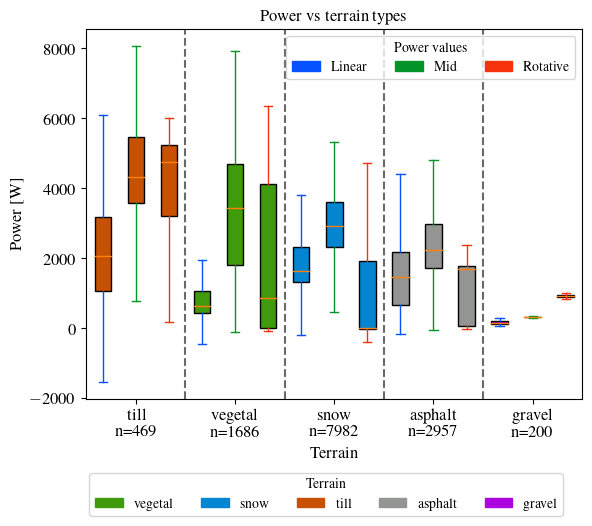

In [10]:
fig, ax = plt.subplots()

xpos_A = 3 * x_pos
xpos_B = 3 * x_pos + 1
xpos_C = 3 * x_pos + 2

# bA : linear
# bB : rotative
bA = ax.boxplot(lin_data, showfliers=False, positions=xpos_A, patch_artist=True)
bB = ax.boxplot(mid_data, showfliers=False, positions=xpos_B, patch_artist=True)
bC = ax.boxplot(rot_data, showfliers=False, positions=xpos_C, patch_artist=True)

for box, col in zip(bA["boxes"], terr_colors):
    box.set_facecolor(col)
for box, col in zip(bB["boxes"], terr_colors):
    box.set_facecolor(col)
for box, col in zip(bC["boxes"], terr_colors):
    box.set_facecolor(col)

for whisk in bA["whiskers"]:
    whisk.set_color(power_colors["linear"])
for elem in bA["caps"]:
    elem.set_color(power_colors["linear"])
for whisk in bB["whiskers"]:
    whisk.set_color(power_colors["mid"])
for elem in bB["caps"]:
    elem.set_color(power_colors["mid"])
for whisk in bC["whiskers"]:
    whisk.set_color(power_colors["rotative"])
for elem in bC["caps"]:
    elem.set_color(power_colors["rotative"])


label_pos = 3 * x_pos + 1
ax.set_xticks(label_pos)
lens = [pA.size for pA in lin_data]
labels = [f"{lab}\nn={n}" for lab, n in zip(terr_labels, lens)]
ax.set_xticklabels(labels)

dividers = 3 * x_pos[1:] - 0.5
for div in dividers:
    ax.axvline(x=div, linestyle="dashed", color="dimgray")


add_terrain_legend(fig)
add_power_legend(ax)

ax.set_ylabel("Power [W]")
ax.set_xlabel("Terrain")

ax.set_title("Power vs terrain types")
fig.savefig(figdir / f"{''.join(abbrs)}_terrain_rho_box.jpg", bbox_inches="tight")


Text(0, 0.5, 'Number of points')

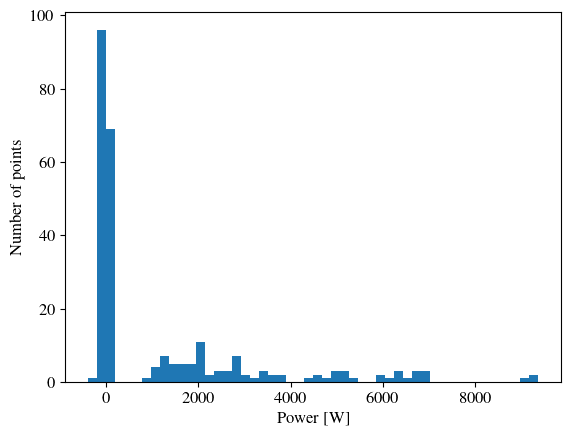

In [11]:
mask = terr_concat_dfs["snow"].rho > rot_th
snow_data = terr_concat_dfs["snow"].P_motion[mask].values
fig, ax = plt.subplots()
ax.hist(snow_data, bins=50)
ax.set_xlabel("Power [W]")
ax.set_ylabel("Number of points")


Text(0, 0.5, 'Number of points')

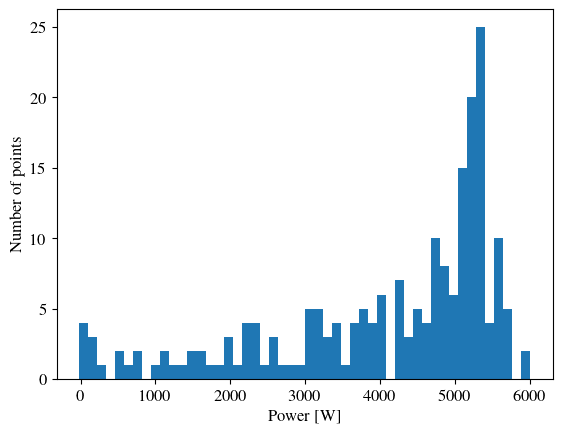

In [12]:
mask = terr_concat_dfs["till"].rho > rot_th
till_data = terr_concat_dfs["till"].P_motion[mask].values
fig, ax = plt.subplots()
ax.hist(till_data, bins=50)
ax.set_xlabel("Power [W]")
ax.set_ylabel("Number of points")

Text(0, 0.5, 'Number of points')

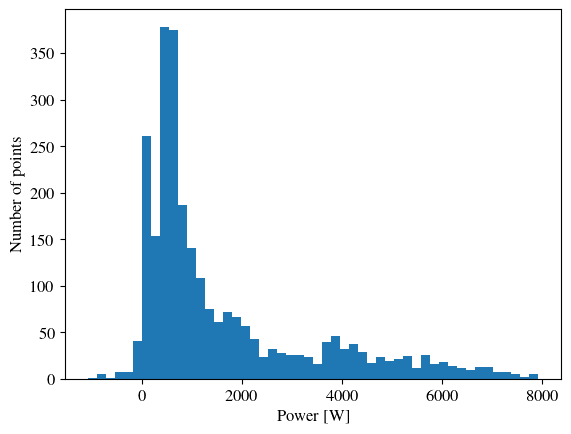

In [13]:
till_data = terr_concat_dfs["vegetal"].P_motion.values
fig, ax = plt.subplots()
ax.hist(till_data, bins=50)
ax.set_xlabel("Power [W]")
ax.set_ylabel("Number of points")

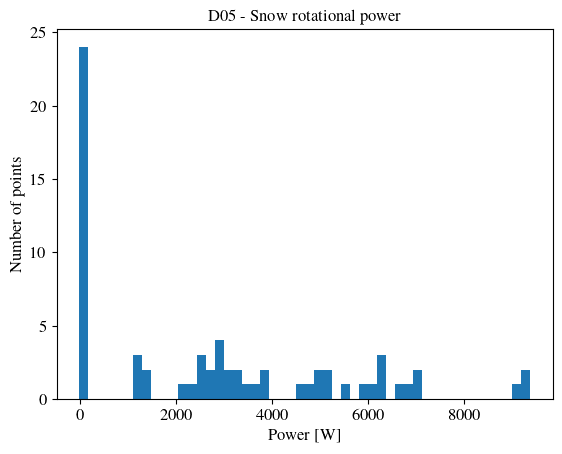

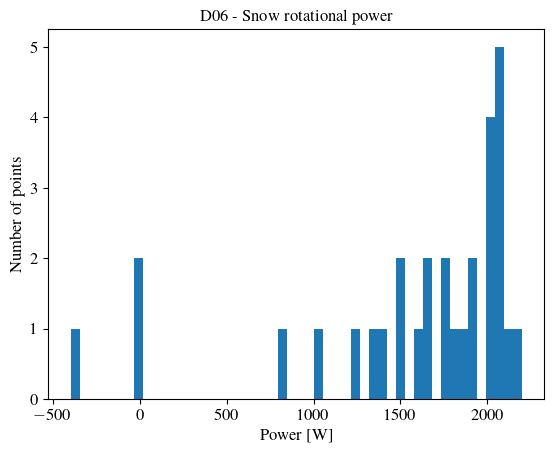

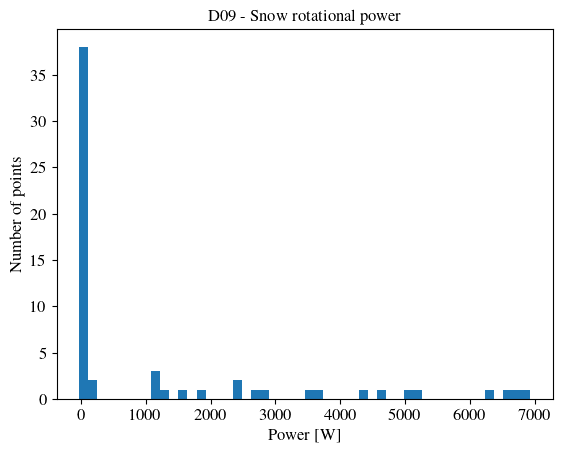

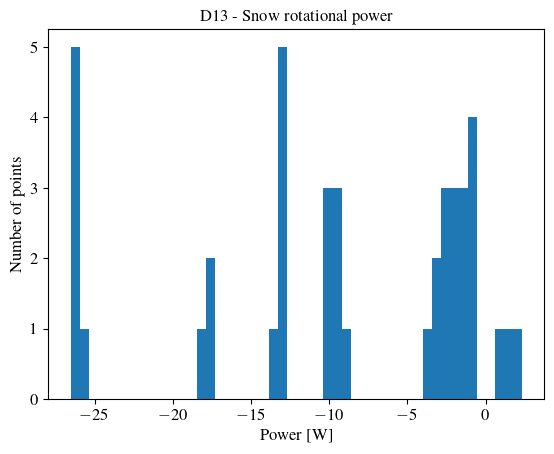

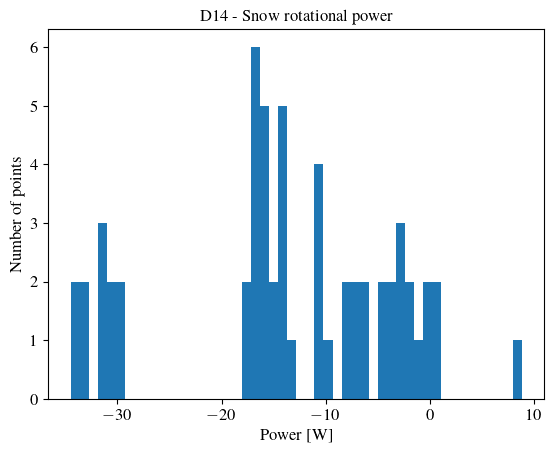

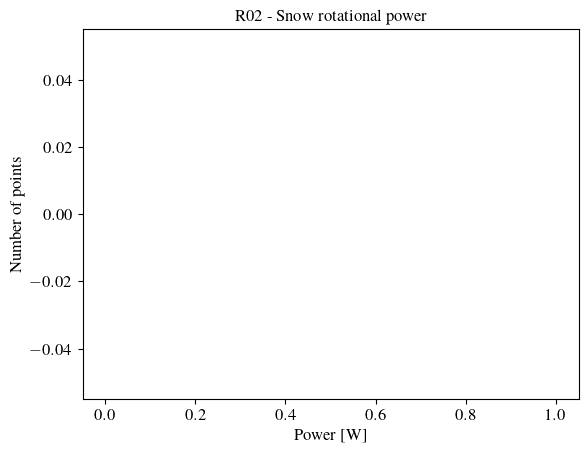

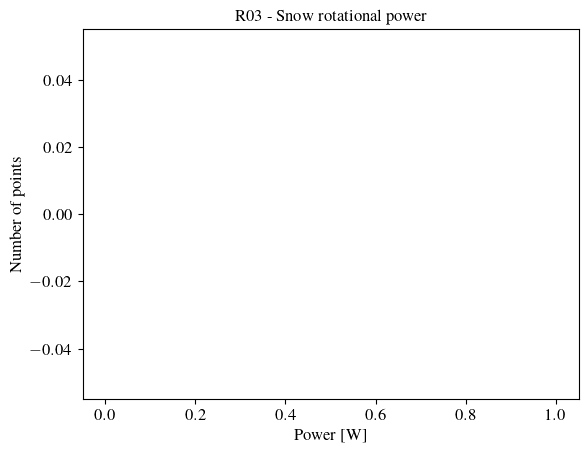

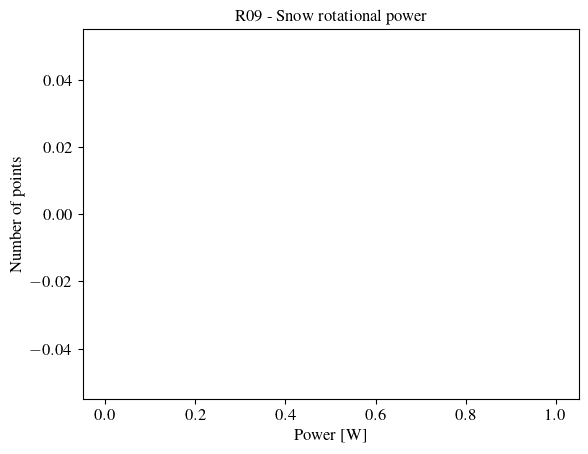

In [14]:
snow_abbrs = terrain_abbrs["snow"]
snow_dfs = terr_dfs["snow"]

for abbr, df in zip(snow_abbrs, snow_dfs):
    Pmotion = df.P_motion
    rho = df.rho
    fig, ax = plt.subplots()
    rot_mask = rho > rot_th
    Prot = Pmotion[rot_mask].values
    ax.hist(Prot, bins=50)
    ax.set_xlabel("Power [W]")
    ax.set_ylabel("Number of points")
    ax.set_title(f"{abbr} - Snow rotational power")
    expdir = u.get_figdir(abbr, rotapentzer2014pow.__MODEL_NAME__.lower())
    fig.savefig(expdir / f"{abbr}_rotpow_snow.jpg", bbox_inches="tight")
